In [225]:
# import required libraries

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=10,6

from pandas import set_option
#set_option('precision',5)
pd.options.display.float_format = '{:.5f}'.format


# Import Libraries and packages from tensorflow.Keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam

In [226]:
# read the data

dataset = pd.read_csv('US_Gold_stockdata2008.csv',index_col='Date',parse_dates=True,infer_datetime_format=True)

In [227]:
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-12-31,843.20001,843.20001,843.20001,834.90002,834.90002,4.00000
2008-01-02,848.70001,857.79999,846.40002,857.00000,857.00000,130.00000
2008-01-03,863.00000,865.50000,856.29999,866.40002,866.40002,181.00000
2008-01-04,861.40002,865.50000,860.20001,863.09998,863.09998,28.00000
2008-01-06,nan,nan,nan,nan,nan,nan


In [228]:
# drop null values and Volume column

dataset.dropna(axis = 0, inplace = True) 
dataset.drop(['Volume','Adj Close'], axis = 1, inplace = True) 

In [229]:
dataset.head()

,Open,High,Low,Close
Date,,,,
2007-12-31,843.20001,843.20001,843.20001,834.90002
2008-01-02,848.70001,857.79999,846.40002,857.00000
2008-01-03,863.00000,865.50000,856.29999,866.40002
2008-01-04,861.40002,865.50000,860.20001,863.09998
2008-01-07,860.90002,860.90002,857.40002,859.59998


In [230]:
datelist = dataset.index
datelist[:5]

DatetimeIndex(['2007-12-31', '2008-01-02', '2008-01-03', '2008-01-04',
               '2008-01-07'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [231]:
print(f"Training set shape: {dataset.shape}")
print(f"Date list shape: {datelist.shape}")
print(f"Features in training set: {dataset.columns}")

Training set shape: (3317, 4)
Date list shape: (3317,)
Features in training set: Index(['Open', 'High', 'Low', 'Close'], dtype='object')


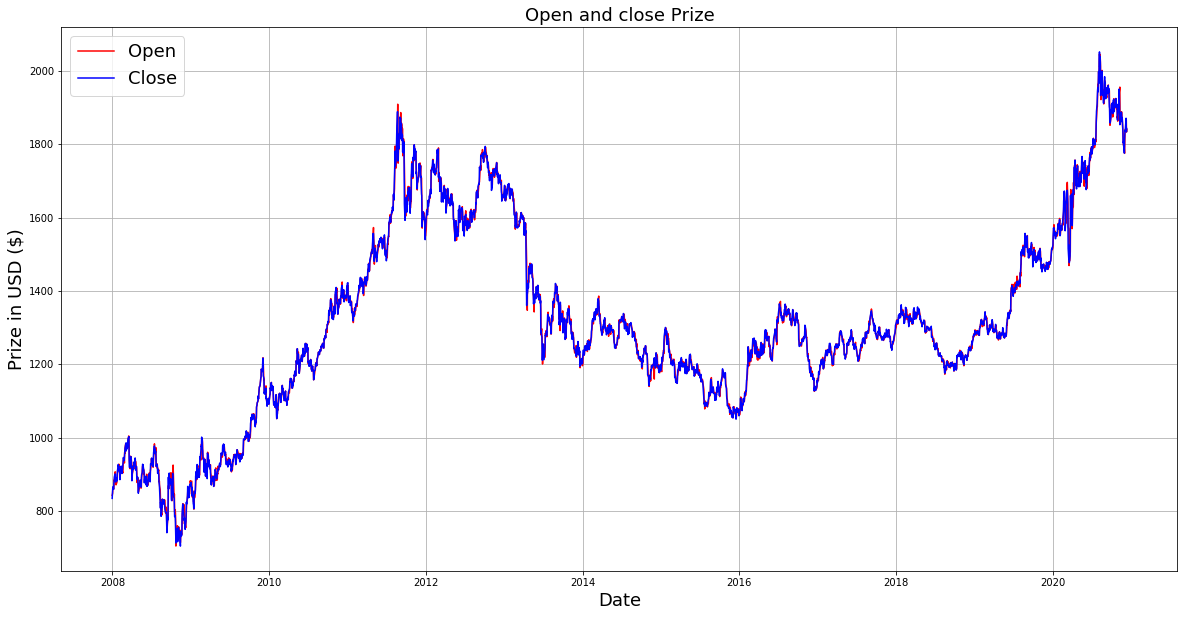

In [232]:
# visualization

plt.figure(figsize=(20,10))
plt.title('Open and close Prize', fontsize=18)
plt.plot(dataset['Open'], label = 'Open', color = 'r')
plt.plot(dataset['Close'], label = 'Close', color = 'b')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Prize in USD ($)', fontsize=18)
plt.legend( fontsize=18)
plt.grid()
plt.show()

In [233]:
# some preprocessing and data preparation steps 

dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3317 entries, 2007-12-31 to 2020-12-11
Data columns (total 4 columns):
Open     3317 non-null float64
High     3317 non-null float64
Low      3317 non-null float64
Close    3317 non-null float64
dtypes: float64(4)
memory usage: 129.6 KB


In [234]:
data = dataset.iloc[:].values
print(f"Shape of traning set: {data.shape}")
data

Shape of traning set: (3317, 4)


array([[ 843.200012,  843.200012,  843.200012,  834.900024],
       [ 848.700012,  857.799988,  846.400024,  857.      ],
       [ 863.      ,  865.5     ,  856.299988,  866.400024],
       ...,
       [1867.099976, 1867.099976, 1827.      , 1834.599976],
       [1833.199951, 1849.099976, 1828.      , 1833.599976],
       [1840.      , 1851.800049, 1826.800049, 1842.699951]])

In [235]:
# all the data should be on the same scale for training RNN network
# because large values can have high impact on the predictions
# And also RNN works well when values are on the same scale

from sklearn.preprocessing import StandardScaler,MinMaxScaler

# one standaard scaler for independent variable 
scaler = MinMaxScaler()
traning_data_scaled = scaler.fit_transform(data)

# one standaard scaler for dependent variable that we want to predict
#scaler_predict = MinMaxScaler()
#predict_data_scaled = scaler_predict.fit_transform(data[:,0:1])
#predict_data_scaled

In [236]:
training_data_len = math.ceil(len(data) * .8) # no of rows o train the model on

training_data_len

2654

In [237]:
# creating the dataset for model traning and prediction
X_train_data = traning_data_scaled[0:training_data_len, :]

X_train = []
y_train = []

#n_future = 60   # number of days we need to predict into future
n_past = 60     # number of days we want to use to predict the future

for i in range(n_past, len(X_train_data)):
    X_train.append(X_train_data[i - n_past:i, 0: X_train_data.shape[1]]) # 0: data.shape[1]-1 # [i - n_past: i, 0: data.shape[1]]
    y_train.append(X_train_data[i, 0])# i + n_future-1:i + n_future
    # i-1:i
    
X_train, y_train = np.array(X_train), np.array(y_train)
    
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (2594, 60, 4)
y_train shape: (2594,)


In [238]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [239]:
X_train.shape

(2594, 60, 4)

In [240]:
# creating the dataset for model prediction
Y_train_data = traning_data_scaled[training_data_len-n_past:, :]

X_test = []
y_test_scaled=[]
y_test = data[training_data_len:, 0]

for i in range(n_past, len(Y_train_data)):
    X_test.append(Y_train_data[i-n_past:i, 0: Y_train_data.shape[1]])
    y_test_scaled.append(Y_train_data[i, 0])#i-1:i
    
X_test, y_test, y_test_scaled = np.array(X_test), np.array(y_test), np.array(y_test_scaled)

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"y_test_scaled shape: {y_test_scaled.shape}")

X_test shape: (663, 60, 4)
y_test shape: (663,)
y_test_scaled shape: (663,)


In [241]:
X_train[0].shape

(60, 4)

In [242]:
# creating a model
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape = X_train[0].shape))

# Adding 2nd LSTM layer
model.add(LSTM(units=32, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.001), loss='mean_squared_error')

In [243]:
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
tb = TensorBoard('logs')

history = model.fit(X_train, y_train, epochs=15, callbacks=[es, rlr], validation_split=0.2, verbose=1, batch_size=128)

Epoch 1/15
17/17 [==============================] - 3s 150ms/step - loss: 0.0346 - val_loss: 0.0035 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - 2s 98ms/step - loss: 0.0072 - val_loss: 5.0852e-04 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - 2s 98ms/step - loss: 0.0046 - val_loss: 2.0806e-04 - lr: 0.0010
Epoch 4/15
17/17 [==============================] - 2s 104ms/step - loss: 0.0037 - val_loss: 2.3097e-04 - lr: 0.0010
Epoch 5/15
17/17 [==============================] - 2s 99ms/step - loss: 0.0036 - val_loss: 1.9528e-04 - lr: 0.0010
Epoch 6/15
17/17 [==============================] - 2s 99ms/step - loss: 0.0032 - val_loss: 1.9520e-04 - lr: 0.0010
Epoch 7/15
17/17 [==============================] - 2s 103ms/step - loss: 0.0030 - val_loss: 2.0226e-04 - lr: 0.0010
Epoch 8/15
17/17 [==============================] - 2s 100ms/step - loss: 0.0029 - val_loss: 1.9056e-04 - lr: 0.0010
Epoch 9/15
17/17 [==============================] - 2s 96ms/step - loss:

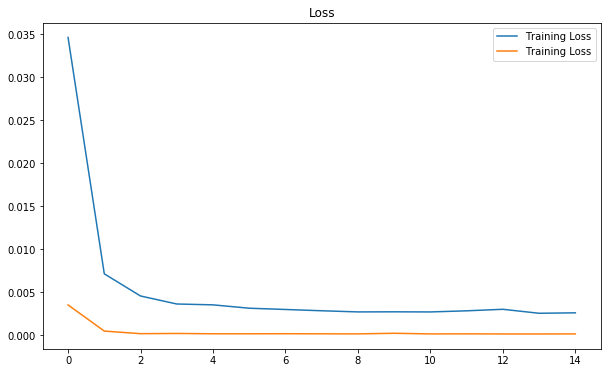

In [244]:
plt.plot(history.history['loss'],label ="Training Loss")
plt.plot(history.history['val_loss'],label ="Validation Loss")
plt.legend()
plt.title("Loss")
plt.show()

In [245]:
predictions = model.predict(X_test)

In [246]:
predictions

array([[0.37227345],
       [0.36922795],
       [0.36676574],
       [0.3649963 ],
       [0.36393857],
       [0.3630133 ],
       [0.36289597],
       [0.36351433],
       [0.36464736],
       [0.36579472],
       [0.36673796],
       [0.3676414 ],
       [0.36799896],
       [0.36811846],
       [0.36827645],
       [0.36825556],
       [0.36803135],
       [0.36776692],
       [0.36792767],
       [0.36821505],
       [0.36824965],
       [0.36835152],
       [0.36838195],
       [0.36858255],
       [0.36905438],
       [0.36920834],
       [0.3693074 ],
       [0.3694399 ],
       [0.3692626 ],
       [0.36860913],
       [0.36777318],
       [0.36681873],
       [0.36643958],
       [0.36631978],
       [0.36643493],
       [0.36677492],
       [0.3666959 ],
       [0.36627823],
       [0.36580873],
       [0.3665602 ],
       [0.36795473],
       [0.3701501 ],
       [0.3727409 ],
       [0.37527   ],
       [0.3777243 ],
       [0.37993804],
       [0.38172278],
       [0.383

In [247]:
len(predictions),len(y_test),len(y_test_scaled)

(663, 663, 663)

In [248]:
predictions[0],y_test[0],y_test_scaled[0]

(array([0.37227345], dtype=float32), 1174.699951, 0.3503916083550914)

In [249]:
Y = pd.DataFrame({
    'Y_test_Actual_scaled':y_test_scaled.ravel(),
    'Y_test_predictions_scaled':predictions.ravel(),
    'Y_test_Actual':y_test
})

In [250]:
Y.head(10)

,Y_test_Actual_scaled,Y_test_predictions_scaled,Y_test_Actual
0,0.35039,0.37227,1174.69995
1,0.35793,0.36923,1184.80005
2,0.36166,0.36677,1189.80005
3,0.36531,0.36500,1194.69995
4,0.36128,0.36394,1189.30005
5,0.35830,0.36301,1185.30005
6,0.37695,0.36290,1210.30005
7,0.37650,0.36351,1209.69995
8,0.37314,0.36465,1205.19995
9,0.37329,0.36579,1205.40002


In [251]:
scaler.scale_[0]

0.0007459903021260724

In [252]:
scaler.data_max_[0]

2045.5

In [253]:
scaler.data_min_[0]

705.0

In [254]:
# inversr transformation using minmax scaler trainer values

x = lambda a: (a*(scaler.data_max_[0] - scaler.data_min_[0])) + scaler.data_min_[0]

In [255]:
Y['Y_test_Actual_Test'] = Y['Y_test_Actual_scaled'].apply(x)
Y['Y_test_predictions_test'] = Y['Y_test_predictions_scaled'].apply(x)

In [264]:
Y.index = datelist[training_data_len:]
Y.tail(20)

,Y_test_Actual_scaled,Y_test_predictions_scaled,Y_test_Actual,Y_test_Actual_Test,Y_test_predictions_test
Date,,,,,
2020-11-12,0.86833,0.87577,1869.00000,1869.00000,1878.97013
2020-11-13,0.87430,0.87392,1877.00000,1877.00000,1876.48532
2020-11-16,0.87251,0.87241,1874.59998,1874.59998,1874.46904
2020-11-17,0.88280,0.87105,1888.40002,1888.40002,1872.64484
2020-11-18,0.87169,0.86989,1873.50000,1873.50000,1871.09159
2020-11-19,0.86595,0.86844,1865.80005,1865.80005,1869.14091
2020-11-20,0.86997,0.86646,1871.19995,1871.19995,1866.48471
2020-11-23,0.84282,0.86470,1834.80005,1834.80005,1864.12478
2020-11-24,0.83872,0.86162,1829.30005,1829.30005,1859.99891


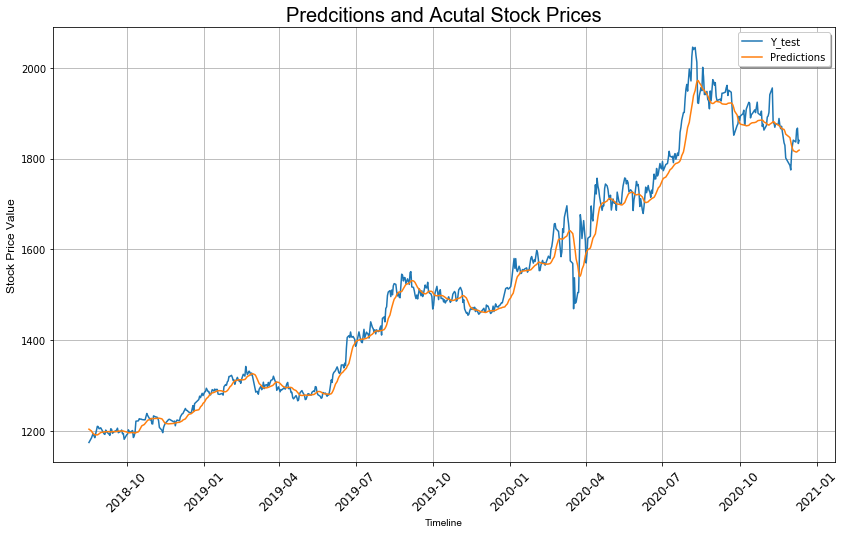

In [314]:
rcParams['figure.figsize'] = 14, 8

plt.plot(Y['Y_test_Actual'], label = 'Y_test')
plt.plot(Y['Y_test_predictions_test'], label = 'Predictions')
#plt.plot(dataset['Open'][:training_data_len])
#plt.plot()

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=20)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.grid()
plt.show()

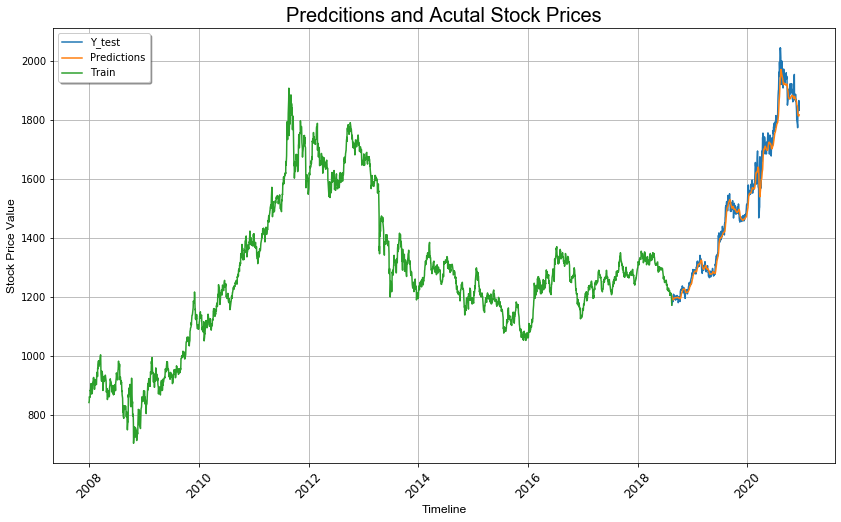

In [313]:
rcParams['figure.figsize'] = 14, 8

plt.plot(Y['Y_test_Actual'], label = 'Y_test')
plt.plot(Y['Y_test_predictions_test'], label = 'Predictions')
plt.plot(dataset['Open'][:training_data_len], label = 'Train')
#plt.plot()

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=20)
plt.xlabel('Timeline', family='Arial', fontsize=12)
plt.ylabel('Stock Price Value', family='Arial', fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.grid()
plt.show()

In [276]:
scaled = scaler.transform(dataset[-n_past:].values)

In [286]:
scaled = np.array(scaled)
scaled = np.reshape(scaled, (1,scaled.shape[0],scaled.shape[1]))

In [287]:
scaled.shape

(1, 60, 4)

In [290]:
prediction_future = model.predict(scaled)

In [298]:
pred = ((prediction_future*(scaler.data_max_[0] - scaler.data_min_[0])) + scaler.data_min_[0])[0][0]

In [300]:
print(f"Prediction for 12.12.2020 = ",pred)

Prediction for 12.12.2020 =  1819.8262
